<a href="https://colab.research.google.com/github/Sebastian-Constantin-Iacob/learning_pytorch/blob/main/PyTorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

In [2]:
# What dose this notebook cover
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all toghether"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all toghether'}

## 1. Data ( preparing and loading )
Data can be almost anything in ML.

* Excel spreadsheets
* Images
* Videos
* Audio
* Text
* DNA
* etc

ML is a game of two parts:
1. Get data in a numerical representation.
2. Build a model to learn patters in that numerical representation.

To shwocase , we shall create some data using linear regression formula.

We'll use a linear regression formula to make a straight line with known parameters.

In [3]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Spliting data into training and test sets

Creating a training and test set with the data.

In [5]:
# create a train/set split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualising data for better understanding

In [6]:
# Function do view data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

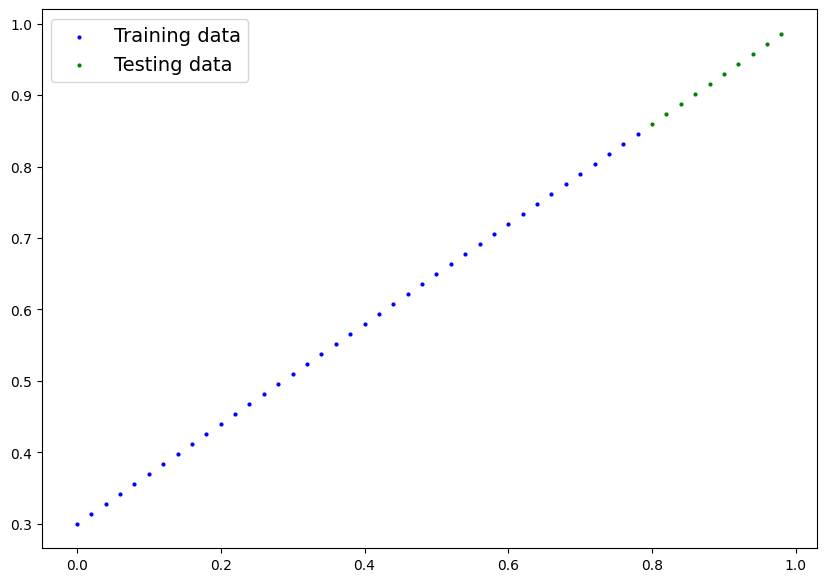

In [7]:
plot_predictions()

## 2. Building model

What are model dose:
* Start with random values ( weight and bias )
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values ( the weight and bias values we use to create the data )

It dose this through 2 main algorythms:
1. Gradient decent.
2. Backpropagation.

In [8]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    
  # Forward method to define the computation in the model
  def forward(self, X: torch.Tensor) -> torch.Tensor: # "X" is the input data
    return self.weights * X + self.bias # Linear regression formula


### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs (a neural network may be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite the forward() method
* torch.optin - This is where a optimizers in PyTorch live, they will help with gradient decent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

## Checking the contents of our PyTorch model

In [9]:
# Create a random seed
torch.manual_seed(42)

# Crete an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, lets see how well it predicts y_test based on x_test.
When we pass data throw our model, it is going to run it through the `forward()` method.

In [12]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

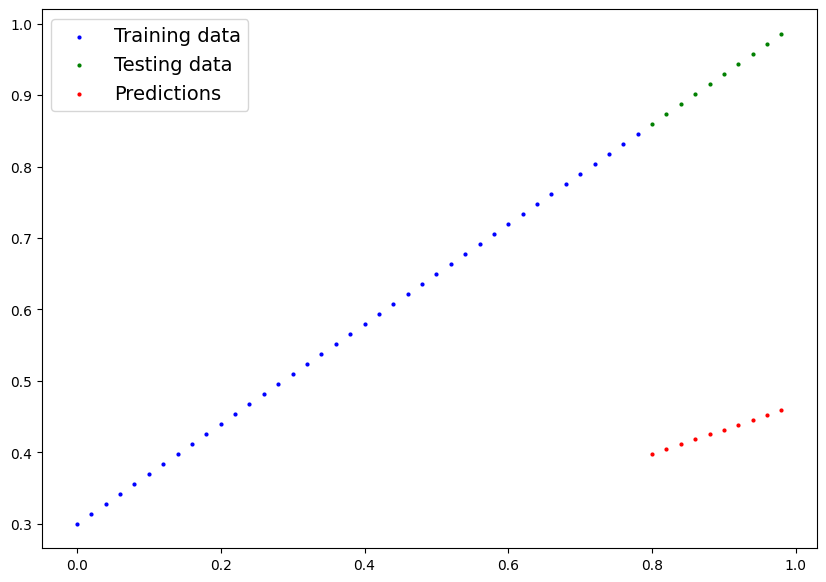

In [13]:
# Let us see our model after one training loop (perfect means green dots overlap with red dots)
plot_predictions(predictions=y_preds)

## 3. Train model

The hole idea of training is for a model to   move from some *unknown* parameters ( these may be random ) to some *known* paramaters.

From a poor representation of data to a better representation of data.

One way to mesure how poor or good our models predictions are, we could use a loss function.

Things we need to train:

* **Loss function** A function to mesure how wrong your models predictions are compared to the actual answer (value).

* **Optimizer:** Takes into account the loss of a model, and adjusts the model's parameters ( e.g weight and bias) to improve the loss function.

Inside the **Optimizer** you will often have to set two parameters:
* params - the model parameters you'd like to optimize, for example `params=model_0.parameters()`
* lr ( learning rate ) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step ( a small `lr` resultss in small changes )

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [14]:
# Set up a loss function
loss_fn = nn.L1Loss()

# Set up an optimizer ( stochastic gradient descent )
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.0001) # Learning rate = possibly the most important hyperparameter you can set

### Building a training and testing loop in PyTorch
A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass ( this involves data moving through our model's `forward()` functions) to make predictions on data
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss baackward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss **backpropagation**
5. Optimizer step - use the optimizer to adjust our model's parameter to improve the loss (**gradient descent**)

In [15]:
# Set up a manual seed
torch.manual_seed(42)

# An epoch is one loop through the data... ( this is a hyperparameter, because we set it our selfes)
epochs = 20000

# Track experiments
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to trainign mode
  model_0.train() # Train mode in PyTorch set all params that require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)
  
  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer 0 grad
  optimizer.zero_grad()

  # 4. Loss backwards ( backpropagation )
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acumulate through the loop. We have to 0 them again at the begining of a new loop ( step 3 )

  ### Testing
  model_0.eval() # Turns off gradient tracking
  with torch.inference_mode(): # turns off gradient tracking and some other things not needed for testing
    # 1. In training, we still use the forward pass method
    test_pred = model_0(X_test)
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Prints out what is happening
  if epoch % 10 == 0:
    # Track for future experiments
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} \n Test: {loss} \n Test loss: {test_loss} \n")
    print(model_0.state_dict())

Streaming output truncated to the last 5000 lines.
Epoch: 10000 
 Test: 0.024338718503713608 
 Test loss: 0.056904666125774384 

OrderedDict([('weights', tensor([0.5789])), ('bias', tensor([0.3508]))])
Epoch: 10010 
 Test: 0.024304334074258804 
 Test loss: 0.05682197958230972 

OrderedDict([('weights', tensor([0.5791])), ('bias', tensor([0.3508]))])
Epoch: 10020 
 Test: 0.024269994348287582 
 Test loss: 0.056742750108242035 

OrderedDict([('weights', tensor([0.5793])), ('bias', tensor([0.3507]))])
Epoch: 10030 
 Test: 0.024235591292381287 
 Test loss: 0.05666007846593857 

OrderedDict([('weights', tensor([0.5794])), ('bias', tensor([0.3506]))])
Epoch: 10040 
 Test: 0.024201255291700363 
 Test loss: 0.05658425763249397 

OrderedDict([('weights', tensor([0.5796])), ('bias', tensor([0.3506]))])
Epoch: 10050 
 Test: 0.024166909977793694 
 Test loss: 0.05650157853960991 

OrderedDict([('weights', tensor([0.5798])), ('bias', tensor([0.3505]))])
Epoch: 10060 
 Test: 0.024132560938596725 
 Tes

In [16]:
epoch_count, loss_values, test_loss_values

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390,
  400,
  410,
  420,
  430,
  440,
  450,
  460,
  470,
  480,
  490,
  500,
  510,
  520,
  530,
  540,
  550,
  560,
  570,
  580,
  590,
  600,
  610,
  620,
  630,
  640,
  650,
  660,
  670,
  680,
  690,
  700,
  710,
  720,
  730,
  740,
  750,
  760,
  770,
  780,
  790,
  800,
  810,
  820,
  830,
  840,
  850,
  860,
  870,
  880,
  890,
  900,
  910,
  920,
  930,
  940,
  950,
  960,
  970,
  980,
  990,
  1000,
  1010,
  1020,
  1030,
  1040,
  1050,
  1060,
  1070,
  1080,
  1090,
  1100,
  1110,
  1120,
  1130,
  1140,
  1150,
  1160,
  1170,
  1180,
  1190,
  1200,
  1210,
  1220,
  1230,
  1240,
  1250,
  1260,
  1270,
  1280,
  1290,
  1300,
  1310,
  1320,
  1330,
  1340,
  1350,
  1360,
  1370,
  1380,

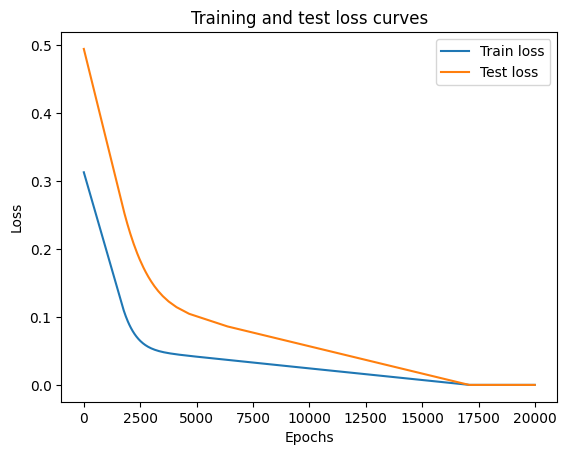

In [17]:
# Plot the loss curves ( remember to transform tensors to numpy, as mathplotlib dose not work with thensors)
plt.plot(
    epoch_count,
    np.array(torch.tensor(loss_values).cpu().numpy()),
    label="Train loss"
)
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

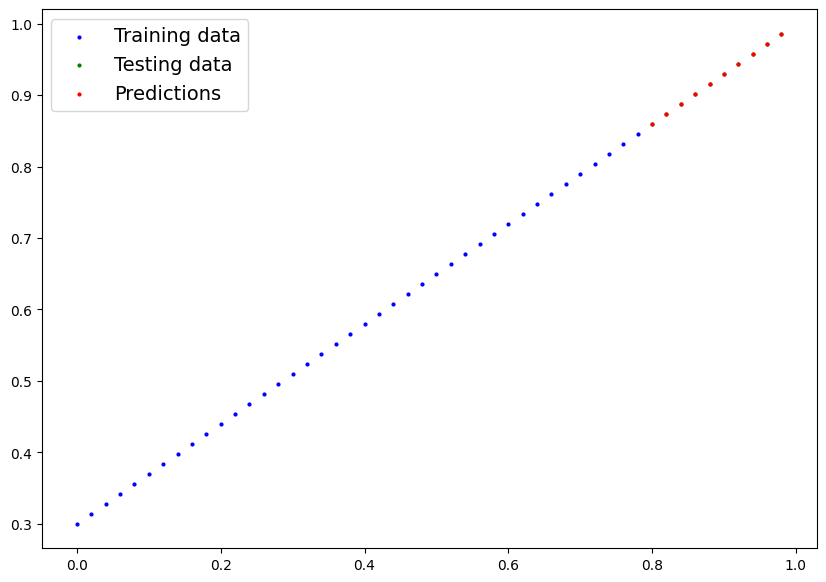

In [18]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds
plot_predictions(predictions=y_preds)

In [19]:
weight, bias

(0.7, 0.3)

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows me to load a model's saved state dictionary

In [21]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])

In [22]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a moidel save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [23]:
# Check models
!ls -l models

total 4
-rw-r--r-- 1 root root 1207 May 25 12:49 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create anew instance of our model class and load the saved `state_dict()` into that.

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])

In [25]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [26]:
# View the state dict, and see if it loaded
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])

In [27]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8599],
        [0.8739],
        [0.8879],
        [0.9019],
        [0.9159],
        [0.9299],
        [0.9439],
        [0.9579],
        [0.9719],
        [0.9859]])

In [28]:
# Compare loaded model predictions with original model predictions
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above, and see it all in one place

In [30]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentiall faster computing ).

If no GPU is available, the code will default to using CPU.

In [31]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [32]:
# In case we want to check the GPU we are using ( if we are using )
!nvidia-smi

/bin/bash: nvidia-smi: command not found


### 6.1 Data

In [33]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create the X and y ( features and labels )
X= torch.arange(start, end, step).unsqueeze(dim=1) # If we don't use unsqueeze, we will have to many dimentions for this test
y = weight * X + bias
X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [34]:
# Split data ( train and test )
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:] 
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

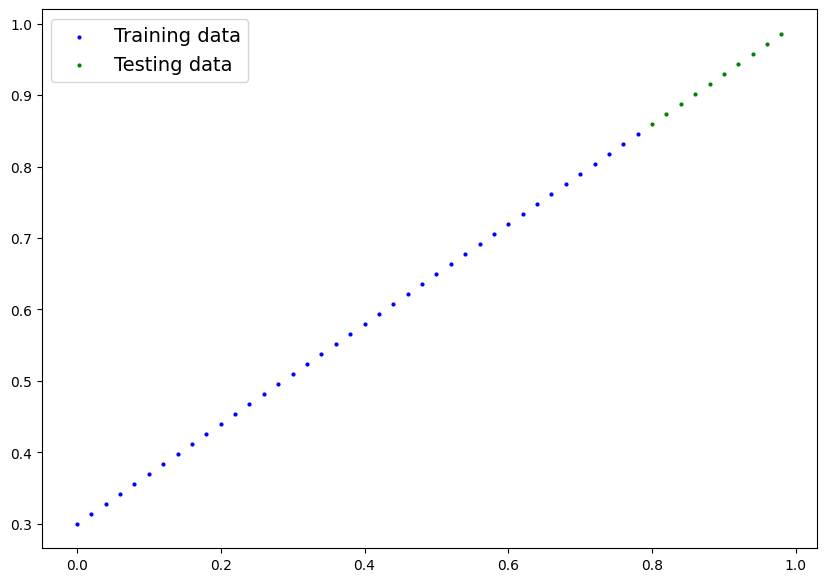

In [35]:
# Plot the data
# Note: if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch linear model